In [0]:
from keras.models import Model, Sequential
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16

In [0]:
import keras.backend as K
import numpy as np
import matplotlib.pyplot as plt

In [0]:
from scipy.optimize import fmin_l_bfgs_b

In [67]:
!pip install import-ipynb
import import_ipynb
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Copy the link and remove the front part of the link (i.e. https://drive.google.com/open?id=) to get the file ID.
your_module = drive.CreateFile({'id':'1OS3WuLk31e5jrMaw3pBT-2A8ZBEfpxX_'})
your_module.GetContentFile('style_transfer_keras.ipynb')
from style_transfer_keras import VGG16_AvgPool, unpreprocess, scale_img

In [0]:
def gram_matrix(img):
  # input is (H, W, C) (C = # feature maps)
  # we first need to convert it to (C, H*W)
  X = K.batch_flatten(K.permute_dimensions(img, (2, 0, 1)))
  
  # now, calculate the gram matrix
  # gram = XX^T / N
  # the constant is not important since we'll be weighting these
  G = K.dot(X, K.transpose(X)) / img.get_shape().num_elements()
  return G

In [0]:
def style_loss(y, t):
  return K.mean(K.square(gram_matrix(y) - gram_matrix(t)))

Mounted at /content/gdrive


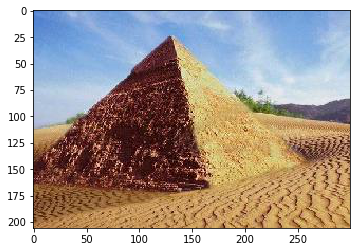

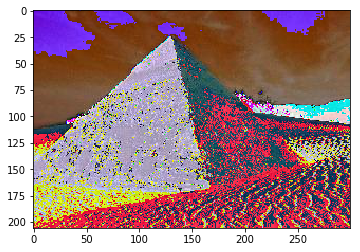

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 206, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 206, 300, 64)      36928     
_________________________________________________________________
average_pooling2d_46 (Averag (None, 103, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 103, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 103, 150, 128)     147584    
_________________________________________________________________
average_pooling2d_47 (Averag (None, 51, 75, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 51, 75, 256)     

In [70]:
if __name__ == '__main__':
  
  from google.colab import drive
  drive.mount('/content/gdrive', force_remount=True)
  
  path = '/content/gdrive/My Drive/Colab Notebooks/Deep Learning: Advanced Computer Vision/image_0003.jpg'
  img = image.load_img(path)
  plt.imshow(img)
  plt.show()
  
  # convert image to array and preprocess for vgg
  x = image.img_to_array(img)          # (206, 300, 3)
  # make it (1, H, W, C)
  x = np.expand_dims(x, axis=0)        # (1, 206, 300, 3)
  # preprocess into VGG expected format
  x = preprocess_input(x)              # (1, 206, 300, 3)
  
  plt.imshow(x[0].astype('uint8'))
  plt.show()

  # we'll use this throughout the rest of the script
  batch_shape = x.shape                # (1, 206, 300, 3)
  shape = x.shape[1:]                  # (206, 300, 3)
  
  # let's take the first convolution at each block of convolutions to be our target outputs
  # remember that you can print out the model summary if you want
  vgg = VGG16_AvgPool(shape)
  vgg.summary()
  
  # Note: need to select output at index 1, since outputs at
  # index 0 correspond to the original vgg with maxpool
  symbolic_conv_outputs = [
    layer.get_output_at(1) for layer in vgg.layers \
    if layer.name.endswith('conv1')
  ]
  
  #print(symbolic_conv_outputs)
  #[<tf.Tensor 'block1_conv1_3/Relu:0' shape=(?, 206, 300, 64) dtype=float32>, 
  # <tf.Tensor 'block2_conv1_3/Relu:0' shape=(?, 103, 150, 128) dtype=float32>, 
  # <tf.Tensor 'block3_conv1_3/Relu:0' shape=(?, 51, 75, 256) dtype=float32>, 
  # <tf.Tensor 'block4_conv1_3/Relu:0' shape=(?, 25, 37, 512) dtype=float32>, 
  # <tf.Tensor 'block5_conv1_3/Relu:0' shape=(?, 12, 18, 512) dtype=float32>]
  
  # make a big model that outputs multiple layers' outputs
  multi_output_model = Model(vgg.input, symbolic_conv_outputs)
  #multi_output_model.summary()             # prints the summary uptil the last conv1
  
  # calculate the targets that are output at each layer
  style_layers_outputs = [K.variable(y) for y in multi_output_model.predict(x)]
  
  # calculate the total style loss
  loss = 0
  for symbolic, actual in zip(symbolic_conv_outputs, style_layers_outputs):
    # gram_matrix() expects a (H, W, C) as input
    loss += style_loss(symbolic[0], actual[0])
  
  